In [1]:
import os
import numpy as np
from scipy.integrate import simpson
from scipy.interpolate import RegularGridInterpolator
from scipy.interpolate import LinearNDInterpolator, griddata
from scipy.integrate import quad
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import pandas as pd

import warnings
# Suppress all warnings
warnings.filterwarnings("ignore")

from matplotlib import rc
rc('font',**{'family':'serif','serif':['serif']})
rc('text', usetex=True)
plt.rcParams['axes.labelsize'] = 17
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['figure.titlesize'] = 20
plt.rcParams['xtick.minor.visible' ] = True
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['ytick.right'] = 'True'
plt.rcParams['xtick.top'] = 'True'
plt.rcParams['xtick.major.pad'] = 10
plt.rcParams['xtick.minor.pad'] = 10
plt.rcParams['ytick.major.pad'] = 10
plt.rcParams['ytick.minor.pad'] = 10
plt.rcParams["figure.subplot.left"] = 0.18
plt.rcParams["figure.subplot.right"] = 0.97
plt.rcParams["figure.subplot.bottom"] = 0.15
plt.rcParams["figure.subplot.top"] = 0.95
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['ytick.major.width'] = 1.5
plt.rcParams['xtick.minor.width'] = 1.5
plt.rcParams['ytick.minor.width'] = 1.5
plt.rcParams['xtick.major.size'] = 9
plt.rcParams['ytick.major.size'] = 9
plt.rcParams['xtick.minor.size'] = 4.5
plt.rcParams['ytick.minor.size'] = 4.5
plt.rcParams['legend.loc'] = 'best'
plt.rcParams['legend.frameon'] = False
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['lines.markersize'] = 15
plt.rcParams['axes.linewidth'] = 2. #frame width
plt.rcParams["figure.figsize"] = (5, 5)

In [2]:
# Ranges used for numerical integration
m_a_intervals = [np.arange(0.1, 1, 0.1),np.arange(1, 10, 1),np.arange(10, 100, 10),np.arange(100, 1100, 100)]
T_intervals = [np.arange(1, 10, 1),np.arange(10, 105, 5)]
mu_e_intervals = [np.arange(10, 100, 5), np.arange(100, 550, 50)]

m_a_range = np.concatenate(m_a_intervals)
T_range = np.concatenate(T_intervals)
mu_e_range = np.concatenate(mu_e_intervals)

In [4]:
alpha_EM=1/137
mec2=0.511
e_charge=(4*np.pi*alpha_EM)**0.5

def me_eff(T, mu_e):
    term1 = mec2 / 2
    term2 = ((mec2**2) / 4 + (e_charge**2 * (mu_e**2 + (np.pi**2) * (T**2))) / (8 * np.pi**2))**(0.5)
    m_eff = term1 + term2
    return m_eff

def m_th(T, mu_e):
    return (2)**(0.5)*me_eff(T, mu_e)

def m_gamma( T, mu_e):
    omega_P=4*alpha_EM/(3*np.pi)*(mu_e**2+np.pi**2*T**2/3)
    return (3*omega_P**2/2)**(0.5)

def bose_einstein(q, T):
    return 1 / (np.exp(q/ T) - 1)

def fermi_dirac_El(p, T, mu_e):
    return 1 / (np.exp((p -  mu_e) / T) + 1)

def fermi_dirac_Pos(p, T, mu_e):
    return 1 / (np.exp((p +  mu_e) / T) + 1)

In [5]:
def get_emissivity_as_function_of_Ea(m_a_query,T_query, mu_e_query, data_file):
    """
    Returns emissivity as a function of E_a[MeV] for given T[MeV], mu_e[MeV], and m_a[MeV] values.
    """
    # Load data
    data = pd.read_csv(data_file, delim_whitespace=True, skiprows=1, names=["m_a", "E_a", "T", "mu_e", "emissivity"])
    
    m_a_vals = np.unique(data["m_a"].values)
    T_vals = np.unique(data["T"].values)
    mu_e_vals = np.unique(data["mu_e"].values)
    
    # Check if queries are within bounds
    if not (m_a_vals[0] <= m_a_query <= m_a_vals[-1]):
        raise ValueError(f"m_a_query={m_a_query} is out of bounds ({m_a_vals[0]} to {m_a_vals[-1]}).")
    if not (T_vals[0] <= T_query <= T_vals[-1]):
        raise ValueError(f"T_query={T_query} is out of bounds ({T_vals[0]} to {T_vals[-1]}).")
    if not (mu_e_vals[0] <= mu_e_query <= mu_e_vals[-1]):
        raise ValueError(f"mu_e_query={mu_e_query} is out of bounds ({mu_e_vals[0]} to {mu_e_vals[-1]}).")
    
    # Filter data for the given m_a
    filtered_data = data[data["m_a"] == m_a_query]
    
    if filtered_data.empty:
        raise ValueError(f"No data found for m_a={m_a_query}.")
    
    # Get unique E_a values for the given m_a
    E_a_vals = np.unique(filtered_data["E_a"].values)
    
    # Reshape emissivity grid
    emissivity_grid = filtered_data.pivot_table(values="emissivity",index="E_a",
        columns=["T", "mu_e"]).values.reshape((len(E_a_vals), len(T_vals), len(mu_e_vals)))
    
    # Create interpolator for T and mu_e
    interpolator = RegularGridInterpolator((E_a_vals, T_vals, mu_e_vals), emissivity_grid, bounds_error=True)
    
    # Interpolate for given T and mu_e
    points = np.array([[E_a, T_query, mu_e_query] for E_a in E_a_vals])
    emissivities = interpolator(points)
    
    return E_a_vals, emissivities

In [6]:
def get_absorption_as_function_of_Ea(m_a_query,T_query, mu_e_query, data_file):
    """
    Returns absorption as a function of E_a[MeV] for given T[MeV], mu_e[MeV], and m_a[MeV] values.
    """
    data = pd.read_csv(data_file, delim_whitespace=True, skiprows=1, names=["m_a", "E_a", "T", "mu_e", "absorption"])
    
    m_a_vals = np.unique(data["m_a"].values)
    T_vals = np.unique(data["T"].values)
    mu_e_vals = np.unique(data["mu_e"].values)
    
    # Check if queries are within bounds
    if not (m_a_vals[0] <= m_a_query <= m_a_vals[-1]):
        raise ValueError(f"m_a_query={m_a_query} is out of bounds ({m_a_vals[0]} to {m_a_vals[-1]}).")
    if not (T_vals[0] <= T_query <= T_vals[-1]):
        raise ValueError(f"T_query={T_query} is out of bounds ({T_vals[0]} to {T_vals[-1]}).")
    if not (mu_e_vals[0] <= mu_e_query <= mu_e_vals[-1]):
        raise ValueError(f"mu_e_query={mu_e_query} is out of bounds ({mu_e_vals[0]} to {mu_e_vals[-1]}).")
    
    # Filter data for the given m_a
    filtered_data = data[data["m_a"] == m_a_query]
    
    if filtered_data.empty:
        raise ValueError(f"No data found for m_a={m_a_query}.")
    
    # Get unique E_a values for the given m_a
    E_a_vals = np.unique(filtered_data["E_a"].values)
    
    # Reshape emissivity grid
    absorption_grid = filtered_data.pivot_table(values="absorption",index="E_a",
        columns=["T", "mu_e"]).values.reshape((len(E_a_vals), len(T_vals), len(mu_e_vals)))
    
    # Create interpolator for T and mu_e
    interpolator = RegularGridInterpolator((E_a_vals, T_vals, mu_e_vals), absorption_grid, bounds_error=True)
    
    # Interpolate for given T and mu_e
    points = np.array([[E_a, T_query, mu_e_query] for E_a in E_a_vals])
    absorption = interpolator(points)
    
    return E_a_vals, absorption

# Emissivity plot

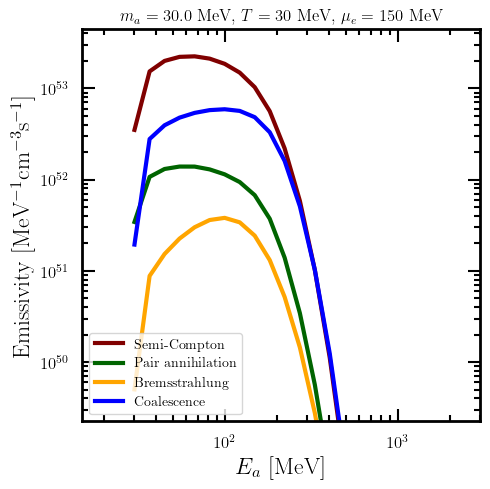

In [7]:
m_a_query = 30 # Axion mass in MeV
T_query = 30.0  # Temperature in MeV
mu_e_query = 150.0  # Electron chemical potential in MeV
E_a_vals, emissivities_Compton = get_emissivity_as_function_of_Ea(m_a_query,T_query, mu_e_query,"Compton_emissivities.dat")
E_a_vals, emissivities_Pair = get_emissivity_as_function_of_Ea(m_a_query,T_query, mu_e_query,"Pair_emissivities.dat")
E_a_vals, emissivities_Bremsstrahlung = get_emissivity_as_function_of_Ea(m_a_query,T_query, mu_e_query,"Bremsstrahlung_emissivities.dat")
E_a_vals, emissivities_Coalescence = get_emissivity_as_function_of_Ea(m_a_query,T_query, mu_e_query,"Coalescence_emissivities.dat")

fig, ax= plt.subplots(figsize=(5,5))

ax.loglog(E_a_vals, emissivities_Compton,  color='maroon', label='Semi-Compton') 
ax.loglog(E_a_vals, emissivities_Pair,  color='darkgreen', label='Pair annihilation') 
ax.loglog(E_a_vals, emissivities_Bremsstrahlung,  color='orange', label='Bremsstrahlung') 
ax.loglog(E_a_vals, emissivities_Coalescence,  color='blue', label='Coalescence') 


ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('$E_{a}$ [MeV]')
ax.set_ylabel('Emissivity [$\mathrm{MeV^{-1} cm^{-3} s^{-1}}$]')
ax.legend(fontsize=10, loc='lower left', frameon=True)
ax.set_title(fr'$m_a={m_a_query:.1f}$ MeV, $T={T_query:.0f}$ MeV, $\mu_e={mu_e_query:.0f}$ MeV', fontsize=12)
ax.set_ylim(1e-4*emissivities_Compton.max(),2*emissivities_Compton.max())  
ax.set_xlim(0.5*E_a_vals.min(),E_a_vals.max())  
plt.tight_layout()


# Absorption plot

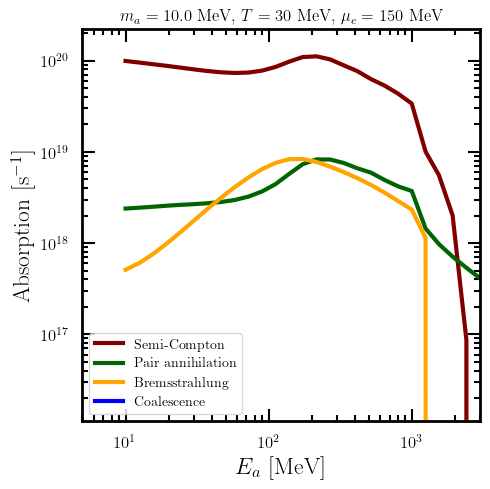

In [8]:
m_a_query = 10 # Axion mass in MeV
T_query = 30.0  # Temperature in MeV
mu_e_query = 150.0  # Electron chemical potential in MeV
E_a_vals, absorption_Compton = get_absorption_as_function_of_Ea(m_a_query,T_query, mu_e_query,"Compton_absorption.dat")
E_a_vals, absorption_Pair = get_absorption_as_function_of_Ea(m_a_query,T_query, mu_e_query,"Pair_absorption.dat")
E_a_vals, absorption_Bremsstrahlung = get_absorption_as_function_of_Ea(m_a_query,T_query, mu_e_query,"Bremsstrahlung_absorption.dat")
E_a_vals, absorption_Coalescence = get_absorption_as_function_of_Ea(m_a_query,T_query, mu_e_query,"Coalescence_absorption.dat")


fig, ax= plt.subplots(figsize=(5,5))

ax.loglog(E_a_vals, absorption_Compton,  color='maroon', label='Semi-Compton') 
ax.loglog(E_a_vals, absorption_Pair,  color='darkgreen', label='Pair annihilation') 
ax.loglog(E_a_vals, absorption_Bremsstrahlung,  color='orange', label='Bremsstrahlung') 
ax.loglog(E_a_vals, absorption_Coalescence,  color='blue', label='Coalescence') 


ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('$E_{a}$ [MeV]')
ax.set_ylabel('Absorption [$\mathrm{ s^{-1}}$]')
ax.legend(fontsize=10, loc='lower left', frameon=True)
ax.set_title(fr'$m_a={m_a_query:.1f}$ MeV, $T={T_query:.0f}$ MeV, $\mu_e={mu_e_query:.0f}$ MeV', fontsize=12)
ax.set_ylim(1e-4*absorption_Compton.max(),2*absorption_Compton.max())  
ax.set_xlim(0.5*E_a_vals.min(),E_a_vals.max())  
plt.tight_layout()
